In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib as plt

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt


Using TensorFlow backend.


In [30]:



dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
data = pd.read_csv("C:/Users/Tsenguunn/Documents/Kaggle/^DJI.csv", parse_dates=['Date'], date_parser=dateparse)
data.set_index('Date', inplace=True)

#data.reset_index(level=0, inplace=True)

In [38]:
data


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-02-17,18019.800781,18052.009766,17951.410156,18047.580078,18047.580078,98760000
2015-02-18,18045.720703,18048.699219,17982.199219,18029.849609,18029.849609,75090000
2015-02-19,18028.669922,18028.669922,17924.599609,17985.769531,17985.769531,79130000
2015-02-20,17985.769531,18144.289063,17878.369141,18140.439453,18140.439453,111390000
2015-02-23,18140.759766,18141.210938,18054.839844,18116.839844,18116.839844,83670000
...,...,...,...,...,...,...
2020-02-10,28995.660156,29278.070313,28995.660156,29276.820313,29276.820313,250510000
2020-02-11,29390.710938,29415.390625,29210.470703,29276.339844,29276.339844,279540000
2020-02-12,29406.750000,29568.570313,29406.750000,29551.419922,29551.419922,309530000


In [135]:
data_len = data.shape[0]
int(np.floor(data_len*0.25))

train_set = data[:'2019-02-14'].iloc[:,3:4].values

test_set = data['2019-02-15':].iloc[:,3:4].values

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

%matplotlib inline
import matplotlib.pyplot as plt

# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
train_set_sc = sc.fit_transform(train_set)

#plt.plot(train_set_sc)

x_train = []
y_train = []

for i in range(60, 1007):
    x_train.append(train_set_sc[i-60:i,0])
    y_train.append(train_set_sc[i,0])
    
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape( x_train, ( x_train.shape[0], x_train.shape[1], 1 ) )



In [121]:
len(train_set_sc)

1007

In [136]:
def return_rmse(test,pred):
    rmse = sqrt(mean_squared_error(test, pred))
    print("The root mean squared error is {}.".format(rmse))
    
def plot_pred(test,pred):
    plt.plot(test, color='red',label='Realized DJIA Index')
    plt.plot(pred, color='blue',label='Predicted DJIA Index')
    plt.title('DJIA Index Prediction')
    plt.xlabel('Date')
    plt.ylabel('DJIA Index')
    plt.legend()
    plt.show()
    
from keras.layers import Flatten

In [162]:

regressor = Sequential()

regressor.add( LSTM(units=50, return_sequences=True, input_shape=( x_train.shape[1],1 ), dropout=0.2 ) ) 
#regressor.add(Dropout(0.2))
regressor.add( LSTM(units=50, return_sequences=True, dropout=0.4) )
#regressor.add(Dropout(0.2))
regressor.add( LSTM(units=50, return_sequences=True, dropout=0.4) )
#regressor.add(Dropout(0.2))
regressor.add( LSTM(units=50, return_sequences=True, dropout=0.4) )
#regressor.add(Dropout(0.2))
#regressor.add( LSTM(units=50, return_sequences=True, dropout=0.2) )
#regressor.add( LSTM(units=50, return_sequences=True, dropout=0.2) )


regressor.add(Flatten())
regressor.add(Dense(units=1))
regressor.compile(optimizer='rmsprop', loss="mean_squared_error")
regressor.fit(x_train, y_train, epochs=5, batch_size=32)

Epoch 1/5
947/947 [==============================] - 26s 28ms/step - loss: 0.0950
Epoch 2/5
947/947 [==============================] - 11s 11ms/step - loss: 0.0628
Epoch 3/5
947/947 [==============================] - 9s 10ms/step - loss: 0.0537
Epoch 4/5
947/947 [==============================] - 9s 9ms/step - loss: 0.0620
Epoch 5/5
947/947 [==============================] - 11s 11ms/step - loss: 0.0502


In [157]:
dt = data['Close']
inp = dt[ len(dt)-len(test_set)-60: ].values
inp = inp.reshape(-1,1)
inp = sc.transform(inp)
inp.shape

(312, 1)

In [139]:
dt[ len(dt)-len(test_set)-60: ]

Date
2018-11-16    25413.220703
2018-11-19    25017.439453
2018-11-20    24465.640625
2018-11-21    24464.689453
2018-11-23    24285.949219
                  ...     
2020-02-10    29276.820313
2020-02-11    29276.339844
2020-02-12    29551.419922
2020-02-13    29423.310547
2020-02-14    29398.080078
Name: Close, Length: 312, dtype: float64

In [152]:
len(inp)

312

In [163]:
x_test = []
for i in range(60,312):
    x_test.append(inp[i-60:i,0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

pred_djia = regressor.predict(x_test)
pred_djia = sc.inverse_transform(pred_djia)

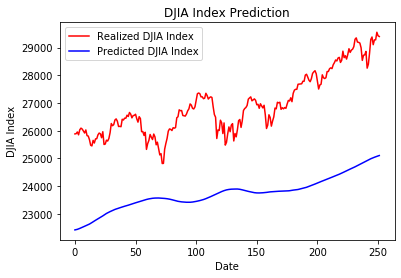

The root mean squared error is 3274.8431167852777.


In [164]:
plot_pred(test_set,pred_djia)
return_rmse(test_set,pred_djia)


In [168]:
test_set

array([[25883.25    ],
       [25891.320313],
       [25954.439453],
       [25850.630859],
       [26031.810547],
       [26091.949219],
       [26057.980469],
       [25985.160156],
       [25916.      ],
       [26026.320313],
       [25819.650391],
       [25806.630859],
       [25673.460938],
       [25473.230469],
       [25450.240234],
       [25650.880859],
       [25554.660156],
       [25702.890625],
       [25709.939453],
       [25848.869141],
       [25914.099609],
       [25887.380859],
       [25745.669922],
       [25962.509766],
       [25502.320313],
       [25516.830078],
       [25657.730469],
       [25625.589844],
       [25717.460938],
       [25928.679688],
       [26258.419922],
       [26179.130859],
       [26218.130859],
       [26384.630859],
       [26424.990234],
       [26341.019531],
       [26150.580078],
       [26157.160156],
       [26143.050781],
       [26412.300781],
       [26384.769531],
       [26452.660156],
       [26449.539063],
       [265

In [169]:
pred_djia

array([[22419.568],
       [22428.188],
       [22440.053],
       [22456.309],
       [22474.012],
       [22494.285],
       [22514.02 ],
       [22534.41 ],
       [22552.309],
       [22571.303],
       [22590.031],
       [22607.896],
       [22631.21 ],
       [22655.826],
       [22684.305],
       [22712.783],
       [22741.186],
       [22767.848],
       [22792.816],
       [22819.1  ],
       [22846.754],
       [22872.4  ],
       [22898.576],
       [22926.158],
       [22955.248],
       [22987.59 ],
       [23013.24 ],
       [23036.602],
       [23059.576],
       [23080.25 ],
       [23100.037],
       [23123.088],
       [23141.443],
       [23158.799],
       [23174.336],
       [23189.094],
       [23203.096],
       [23217.297],
       [23232.285],
       [23246.71 ],
       [23260.64 ],
       [23273.879],
       [23285.375],
       [23298.936],
       [23311.975],
       [23325.664],
       [23338.88 ],
       [23354.002],
       [23369.633],
       [23383.395],


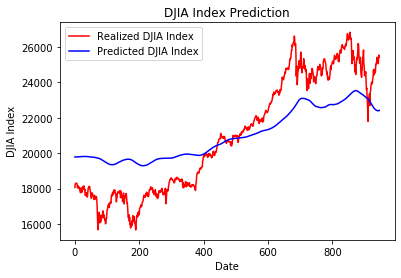

In [165]:
trnd_djia = regressor.predict(x_train)
trnd_djia = sc.inverse_transform(trnd_djia)
y_tr_sc = sc.inverse_transform(y_train.reshape(-1,1))
plot_pred( y_tr_sc, trnd_djia )

In [175]:
from keras.layers import GRU
from keras.optimizers import SGD

In [176]:

regressorGRU = Sequential()
regressorGRU.add( GRU( units=50, return_sequences=True, input_shape=(x_train.shape[1],1), activation='tanh', dropout=0.2 ) )
regressorGRU.add( GRU( units=50, return_sequences=True, input_shape=(x_train.shape[1],1), activation='tanh', dropout=0.2 ) )
regressorGRU.add( GRU( units=50, return_sequences=True, input_shape=(x_train.shape[1],1), activation='tanh', dropout=0.2 ) )

regressorGRU.add( GRU(units=50, activation='tanh', dropout=0.2 ) )

#regressorGRU.add(Flatten())
regressorGRU.add(Dense(units=1))

regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')

regressorGRU.fit(x_train,y_train,epochs=5,batch_size=150)


Epoch 1/5
947/947 [==============================] - 17s 18ms/step - loss: 0.1433
Epoch 2/5
947/947 [==============================] - 4s 5ms/step - loss: 0.1024
Epoch 3/5
947/947 [==============================] - 5s 6ms/step - loss: 0.0769
Epoch 4/5
947/947 [==============================] - 4s 5ms/step - loss: 0.0545
Epoch 5/5
947/947 [==============================] - 4s 4ms/step - loss: 0.0477


In [179]:
pred_djia_gru = regressorGRU.predict(x_test)
pred_djia_gru = sc.inverse_transform(pred_djia_gru)

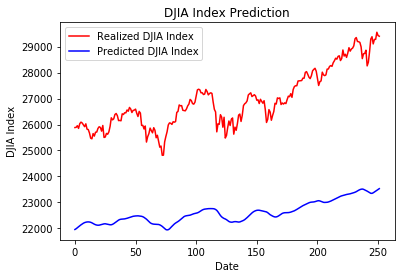

In [180]:
plot_pred(test_set,pred_djia_gru)

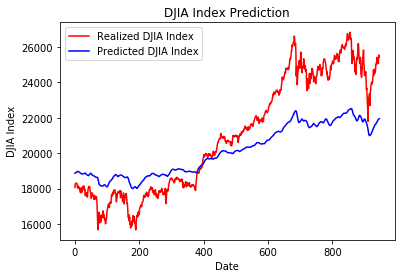

In [181]:
trnd_djia_gru = regressorGRU.predict(x_train)
trnd_djia_gru = sc.inverse_transform(trnd_djia_gru)
y_tr_sc = sc.inverse_transform(y_train.reshape(-1,1))
plot_pred( y_tr_sc, trnd_djia_gru )

In [286]:
import statsmodels.api as sm
x_train_cyc, x_train_tre = sm.tsa.filters.hpfilter(train_set,1600)


from sklearn.preprocessing import StandardScaler

x_train_tre = train_set

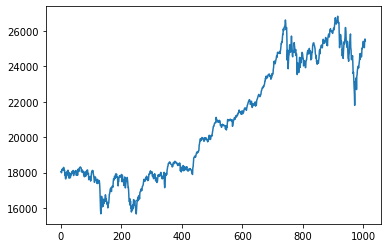

In [287]:
plt.plot(x_train_tre)

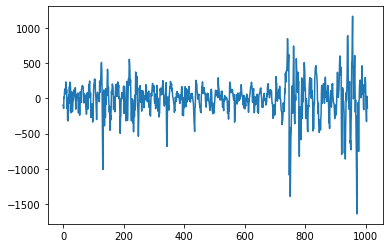

In [188]:
plt.plot(x_train_cyc)

(1007,)

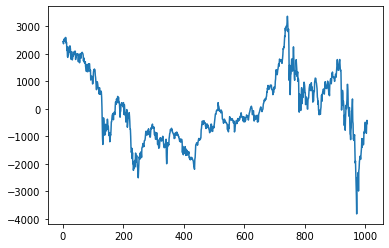

In [321]:
len(x_train_tre)
np.ones([len(x_train_tre),1])
x_tre_mat = np.concatenate( ( np.ones([len(x_train_tre),1]), np.arange(len(x_train_tre)).reshape(-1,1) ), axis=1 )
time_ols = ( np.linalg.inv( x_tre_mat.transpose().dot(x_tre_mat) ) ).dot( x_tre_mat.transpose().dot(x_train_tre) )
#np.arange(len(x_train_tre))

time_trend = time_ols[0]+np.arange(len(x_train_tre))*time_ols[1]

#plt.plot(time_trend, color='red',label='Time Triend')
#plt.plot(x_train_tre, color='blue',label='DJIA Index')

x_train_tre_tt = np.subtract( x_train_tre, time_trend.reshape(-1,1) )

x_train_tre_tt = x_train_tre_tt.reshape(-1,1)
plt.plot(x_train_tre_tt)
#plt.plot(time_trend)
x_train_tre.shape
time_trend.shape

In [289]:
# Scaling the training set
#sc_tre = MinMaxScaler(feature_range=(0,1))
sc_tre = StandardScaler()

x_train_tre = x_train_tre.reshape(-1, 1)

#np.ones(len(x_train_tre),1)

#x_train_tre_tt = x_train_tre-time_trend

train_set_tre_sc = sc_tre.fit_transform( x_train_tre_tt.reshape(-1,1) )

#plt.plot(train_set_sc)

x_train_trend = []
y_train_trend = []

for i in range(60, 1007):
    x_train_trend.append(train_set_tre_sc[i-60:i,0])
    y_train_trend.append(train_set_tre_sc[i,0])
    
x_train_trend, y_train_trend = np.array(x_train_trend), np.array(y_train_trend)

x_train_trend = np.reshape( x_train_trend, ( x_train_trend.shape[0], x_train_trend.shape[1], 1 ) )


In [290]:
regressorGRU_tre = Sequential()
regressorGRU_tre.add( GRU( units=450, return_sequences=True, input_shape=(x_train_trend.shape[1],1), activation='tanh', dropout=0.2 ) )
regressorGRU_tre.add( GRU( units=450, return_sequences=True, input_shape=(x_train_trend.shape[1],1), activation='tanh', dropout=0.2 ) )
regressorGRU_tre.add( GRU( units=450, return_sequences=True, input_shape=(x_train_trend.shape[1],1), activation='tanh', dropout=0.2 ) )

#regressorGRU_tre.add( GRU( units=250, return_sequences=True, input_shape=(x_train_trend.shape[1],1), activation='tanh', dropout=0.2 ) )
#regressorGRU_tre.add( GRU( units=250, return_sequences=True, input_shape=(x_train_trend.shape[1],1), activation='tanh', dropout=0.2 ) )

regressorGRU_tre.add( GRU(units=450, activation='tanh', dropout=0.2 ) )

regressorGRU_tre.add(Dense(units=1))

regressorGRU_tre.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')

regressorGRU_tre.fit(x_train_trend, y_train_trend, epochs=5, batch_size=150)

Epoch 1/5
947/947 [==============================] - 75s 80ms/step - loss: 0.6638
Epoch 2/5
947/947 [==============================] - 28s 30ms/step - loss: 0.3375
Epoch 3/5
947/947 [==============================] - 31s 33ms/step - loss: 0.2579
Epoch 4/5
947/947 [==============================] - 29s 30ms/step - loss: 0.2516
Epoch 5/5
947/947 [==============================] - 26s 27ms/step - loss: 0.2381


In [214]:
x_train_trend.shape[1]

60

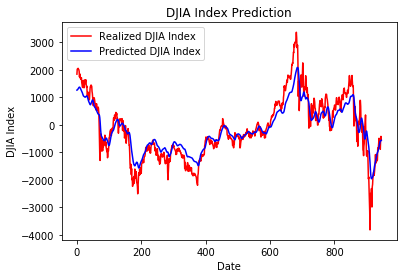

In [310]:
trnd_djia_gru_tre = regressorGRU_tre.predict(x_train_trend)
trnd_djia_gru_tre = sc_tre.inverse_transform(trnd_djia_gru_tre)
y_tr_sc_tre = sc_tre.inverse_transform(y_train_trend.reshape(-1,1))
plot_pred( y_tr_sc_tre, trnd_djia_gru_tre )






In [366]:
#y_tr_sc_tre

In [365]:
#trnd_djia_gru_tre

In [357]:

dt = data['Close']
inp = dt[ len(dt)-len(test_set)-60: ].values
inp = inp.reshape(-1,1)

time_trend_ext = np.arange(len(inp))*time_ols[1]+time_trend[-60]

inp = np.subtract(inp, time_trend_ext.reshape(-1,1))

inp = sc_tre.transform(inp)





In [349]:
len(dt)-len(test_set)

1007

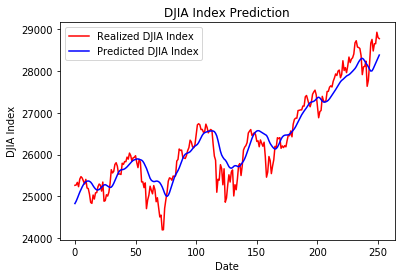

In [359]:
x_test = []
y_test = []

for i in range(60,312):
    x_test.append(inp[i-60:i,0])
    y_test.append(inp[i,0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

pred_djia_tt = regressorGRU_tre.predict(x_test)


pred_djia_tt = sc_tre.inverse_transform(pred_djia_tt)
y_test = sc_tre.inverse_transform(np.array(y_test).reshape(-1,1))

y_test = y_test + time_trend_ext.reshape(-1,1)[:-60]
pred_djia_tt = pred_djia_tt + time_trend_ext.reshape(-1,1)[:-60]

plot_pred(y_test,pred_djia_tt)

#plot_pred(dt[ len(dt)-len(test_set): ].values.reshape(-1,1),pred_djia_tt)